<a href="https://colab.research.google.com/github/DaniilAszn/ML2_course/blob/main/4_%D0%91%D0%B0%D1%82%D1%87_%D0%BD%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8_%D0%BF%D0%B5%D1%80%D0%B5%D0%BD%D0%BE%D1%81_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **4 практика по NN by RTU MIREA**

## **Часть 1: Batch normalization.**

Продолжаем совершенствовать наш ЛеНет.

<center>
<img src="https://neurohive.io/wp-content/uploads/2018/08/perseptron-mnogosloinyi.gif" width="700">
</center>

## Шаг 0: Подготовка датасета CIFAR10

In [ ]:
# Импортируем необходимые библиотеки
import torch as tch
import numpy as np
import matplotlib.pyplot as plt
import random

plt.style.use('ggplot')
%matplotlib inline

# Сделаем инициализацию random seed,
# чтобы наши эксперименты были воспроизводимы и на других ноутбуках
random.seed(0)
np.random.seed(0)
tch.manual_seed(0)
tch.cuda.manual_seed(0)
tch.backends.cudnn.deterministic=True

In [ ]:
import torchvision.datasets

CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

100%|██████████| 170498071/170498071 [00:02<00:00, 74713752.68it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [ ]:
# FloatTensor - картинки
# LongTensor - классы
X_train = tch.FloatTensor(CIFAR_train.data)
y_train = tch.LongTensor(CIFAR_train.targets)
X_test = tch.FloatTensor(CIFAR_test.data)
y_test = tch.LongTensor(CIFAR_test.targets)

In [ ]:
# Нормировка
X_train /= 255.
X_test /= 255.

In [ ]:
# Настройка размера тензора
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

## Шаг 1: Построение свёрточной нейронной сети

In [ ]:
class CNNLeNet(tch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5,
                 batch_norm=False):
        super(CNNLeNet, self).__init__()

        # АРХИТЕКТУРНЫЕ ПАРАМЕТРЫ:

        # флаг использования батч нормализации
        self.batch_norm = batch_norm

        # задаём размер свёртки
        self.conv_size = conv_size

        # выбор функции активации
        if activation == 'tanh':
            activation_function = tch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = tch.nn.ReLU()
        else:
            raise NotImplementedError

        # выбор пуллинга
        if pooling == 'avg':
            pooling_layer = tch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = tch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError

        # АРХИТЕКТУРА CNN LeNet:

        # выбор 1 свёртки
        if conv_size == 5:
            self.conv1 = tch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv1_1 = tch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=0)
            self.conv1_2 = tch.nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act1 = activation_function

        self.bn1 = tch.nn.BatchNorm2d(num_features=6)

        self.pool1 = pooling_layer

        # выбор 2 свёртки
        if conv_size == 5:
            self.conv2 = self.conv2 = tch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = tch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = tch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function

        self.bn2 = tch.nn.BatchNorm2d(num_features=16)

        self.pool2 = pooling_layer

        self.fc1 = tch.nn.Linear(5 * 5 * 16, 120) # замена свёртки в архитектуре

        self.act3 = activation_function

        self.fc2 = tch.nn.Linear(120, 84)

        self.act4 = activation_function

        self.fc3 = tch.nn.Linear(84, 10)


    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))

        x = self.act1(x)

        if self.batch_norm:
            x = self.bn1(x)

        x = self.pool1(x)

        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))

        x = self.act2(x)

        if self.batch_norm:
            x = self.bn2(x)

        x = self.pool2(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)

        x = self.act3(x)

        x = self.fc2(x)

        x = self.act4(x)

        x = self.fc3(x)

        return x

## Шаг 2: Обучение


In [ ]:
def train(net, X_train, y_train, X_test, y_test):
    loss = tch.nn.CrossEntropyLoss() # функция потерь
    optimizer = tch.optim.Adam(net.parameters(), lr=0.001) # оптимизатор

    batch_size = 150 # размер батча (пакета)
    epochs = 20 #число эпох

    test_loss_history = [] # значения для функции потерь

    for epoch in range(epochs):
        order = np.random.permutation(len(X_train)) # индексы объектов, отвечает
                                                    # за порядок элементов
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad() # делаем, чтоб не добавлял градиенты с прошлой
                                  # итерации
            net.train()

            batch_indexes = order[start_index:start_index + batch_size]

            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward() # обратный проход: вычисляем градиенты для
                                  # обновления весов

            optimizer.step() # обновление весов

        net.eval()
        test_preds = net.forward(X_test)
        print(f'Эпоха №{epoch + 1}: loss = {loss(test_preds, y_test).data.cpu()}')
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

    del net

    return test_loss_history


In [ ]:
# Словарь, хранящий значения функции потерь для каждой из настроек CNN
loss_dict = {}

In [ ]:
# Лоссы для исходного ЛеНета
loss_dict['tanh'] = train(CNNLeNet(activation='tanh', conv_size=5),
                                            X_train,
                                            y_train,
                                            X_test,
                                            y_test)

Эпоха №1: loss = 1.7569386959075928
Эпоха №2: loss = 1.6412476301193237
Эпоха №3: loss = 1.5373069047927856
Эпоха №4: loss = 1.4634369611740112
Эпоха №5: loss = 1.4491194486618042
Эпоха №6: loss = 1.3838404417037964
Эпоха №7: loss = 1.346664547920227
Эпоха №8: loss = 1.3478461503982544
Эпоха №9: loss = 1.311345100402832
Эпоха №10: loss = 1.3011651039123535
Эпоха №11: loss = 1.283653974533081
Эпоха №12: loss = 1.272520661354065
Эпоха №13: loss = 1.2800012826919556
Эпоха №14: loss = 1.2811769247055054
Эпоха №15: loss = 1.2803043127059937
Эпоха №16: loss = 1.271633267402649
Эпоха №17: loss = 1.2692248821258545
Эпоха №18: loss = 1.2839080095291138
Эпоха №19: loss = 1.2851035594940186
Эпоха №20: loss = 1.2885571718215942


In [ ]:
# Лоссы для ЛеНета с функцией активации ReLu
loss_dict['relu'] = train(CNNLeNet(activation='relu', conv_size=5),
                                            X_train,
                                            y_train,
                                            X_test,
                                            y_test)

Эпоха №1: loss = 1.662528157234192
Эпоха №2: loss = 1.5487878322601318
Эпоха №3: loss = 1.4556007385253906
Эпоха №4: loss = 1.4078662395477295
Эпоха №5: loss = 1.3787521123886108
Эпоха №6: loss = 1.3309309482574463
Эпоха №7: loss = 1.3151963949203491
Эпоха №8: loss = 1.284311056137085
Эпоха №9: loss = 1.2699319124221802
Эпоха №10: loss = 1.2602530717849731
Эпоха №11: loss = 1.2372099161148071
Эпоха №12: loss = 1.2327791452407837
Эпоха №13: loss = 1.2161617279052734
Эпоха №14: loss = 1.2180988788604736
Эпоха №15: loss = 1.1787371635437012
Эпоха №16: loss = 1.2517874240875244
Эпоха №17: loss = 1.18796968460083
Эпоха №18: loss = 1.1784588098526
Эпоха №19: loss = 1.1626173257827759
Эпоха №20: loss = 1.1642173528671265


In [ ]:
# Лоссы для ЛеНета с функцией активации ReLu, макс пуллингом
loss_dict['relu_max_pool'] = train(CNNLeNet(activation='relu', conv_size=5, pooling='max'),
                                                                  X_train,
                                                                  y_train,
                                                                  X_test,
                                                                  y_test)

Эпоха №1: loss = 1.6390929222106934
Эпоха №2: loss = 1.5034295320510864
Эпоха №3: loss = 1.4275909662246704
Эпоха №4: loss = 1.403283953666687
Эпоха №5: loss = 1.3031620979309082
Эпоха №6: loss = 1.3136521577835083
Эпоха №7: loss = 1.251950740814209
Эпоха №8: loss = 1.2286996841430664
Эпоха №9: loss = 1.2082343101501465
Эпоха №10: loss = 1.1751279830932617
Эпоха №11: loss = 1.159233570098877
Эпоха №12: loss = 1.1497139930725098
Эпоха №13: loss = 1.1391719579696655
Эпоха №14: loss = 1.1131811141967773
Эпоха №15: loss = 1.1269927024841309
Эпоха №16: loss = 1.0815683603286743
Эпоха №17: loss = 1.098984718322754
Эпоха №18: loss = 1.083213448524475
Эпоха №19: loss = 1.09690523147583
Эпоха №20: loss = 1.0746617317199707


In [ ]:
# Лоссы для ЛеНета с функцией активации ReLu, макс пуллингом, двумя свёртками 3х3
loss_dict['relu_max_pool_3x3'] = train(CNNLeNet(activation='relu', conv_size=3, pooling='max'),
                                                X_train,
                                                y_train,
                                                X_test,
                                                y_test)

Эпоха №1: loss = 1.6172317266464233
Эпоха №2: loss = 1.4409596920013428
Эпоха №3: loss = 1.3549517393112183
Эпоха №4: loss = 1.2837127447128296
Эпоха №5: loss = 1.266848087310791
Эпоха №6: loss = 1.2033499479293823
Эпоха №7: loss = 1.1619142293930054
Эпоха №8: loss = 1.1417025327682495
Эпоха №9: loss = 1.1072498559951782
Эпоха №10: loss = 1.090051293373108
Эпоха №11: loss = 1.070992112159729
Эпоха №12: loss = 1.0673657655715942
Эпоха №13: loss = 1.0552223920822144
Эпоха №14: loss = 1.0527429580688477
Эпоха №15: loss = 1.037874698638916
Эпоха №16: loss = 1.0352903604507446
Эпоха №17: loss = 1.0533809661865234
Эпоха №18: loss = 1.0387235879898071
Эпоха №19: loss = 1.036367416381836
Эпоха №20: loss = 1.0395863056182861


In [ ]:
# Лоссы для ЛеНета с функцией активации ReLu, макс пуллингом, двумя свёртками 3х3, батч нормализацией
loss_dict['relu_max_pool_3x3_bn'] = train(CNNLeNet(activation='relu', conv_size=3, pooling='max', batch_norm=True),
                                                X_train,
                                                y_train,
                                                X_test,
                                                y_test)

Эпоха №1: loss = 1.3158961534500122
Эпоха №2: loss = 1.122897982597351
Эпоха №3: loss = 1.0369693040847778
Эпоха №4: loss = 1.059630036354065
Эпоха №5: loss = 1.0368374586105347
Эпоха №6: loss = 0.9482852816581726
Эпоха №7: loss = 0.9543663263320923
Эпоха №8: loss = 0.9707106351852417
Эпоха №9: loss = 0.9789006114006042
Эпоха №10: loss = 0.9953840970993042
Эпоха №11: loss = 1.0130250453948975
Эпоха №12: loss = 1.0457326173782349
Эпоха №13: loss = 1.0418106317520142
Эпоха №14: loss = 1.103560447692871
Эпоха №15: loss = 1.1278311014175415
Эпоха №16: loss = 1.1782115697860718
Эпоха №17: loss = 1.196764588356018
Эпоха №18: loss = 1.2296472787857056
Эпоха №19: loss = 1.2983351945877075
Эпоха №20: loss = 1.3251982927322388


## Шаг 3: Визуализация результатов



Text(0, 0.5, 'loss value')

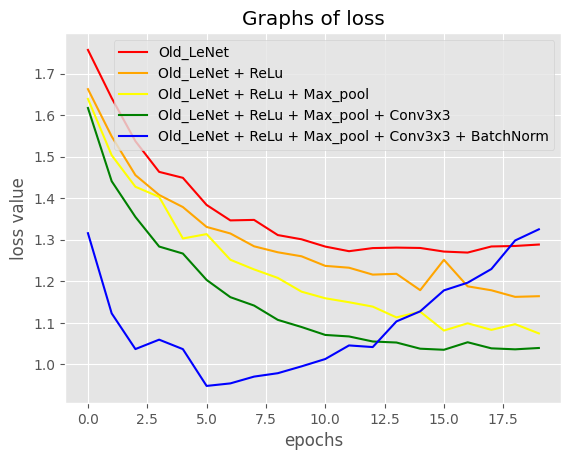

In [ ]:
plt.title('Graphs of loss')
plt.plot(loss_dict['tanh'], label='Old_LeNet', c='red')
plt.plot(loss_dict['relu'], label='Old_LeNet + ReLu', c='orange')
plt.plot(loss_dict['relu_max_pool'], label='Old_LeNet + ReLu + Max_pool', c='yellow')
plt.plot(loss_dict['relu_max_pool_3x3'], label='Old_LeNet + ReLu + Max_pool + Conv3x3', c='green')
plt.plot(loss_dict['relu_max_pool_3x3_bn'], label='Old_LeNet + ReLu + Max_pool + Conv3x3 + BatchNorm', c='blue')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss value')

### Выводы:
1. При батч нормализации нейросеть учится быстро;
2. Начиная с 5-ой эпохи происходит переобучение;
3. Быстро учимся, быстро переобучимся.

## **Часть 2: Transfer learning.**

Рано или поздно каждый из нас приходит к осознанию того, что обучать нейронки либо долго, либо дорого. На помощь в этой ситуации к нам приходит метод под названием transfer learning.

<center>

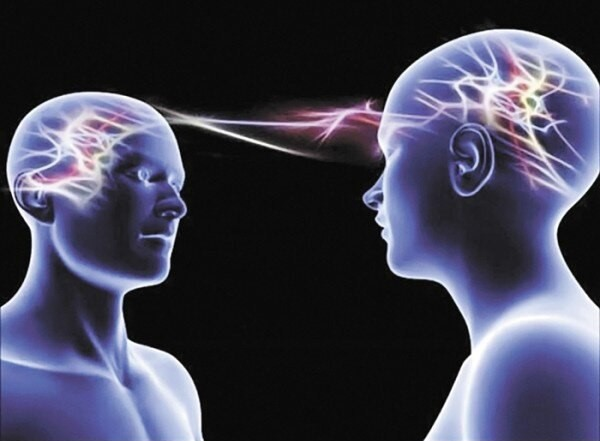

</center>

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch as tch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from tqdm.notebook import tqdm
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-1-9bf24d7e1a2d>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
random.seed(123)
np.random.seed(123)
tch.manual_seed(123)
tch.cuda.manual_seed(123)
tch.backends.cudnn.deterministic=True

In [3]:
device = tch.device('cuda:0' if tch.cuda.is_available() else 'cpu')

## Шаг 0: Подгружаем датасет

In [4]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.STL10(root='./data', download=True, split='train', transform=transform)
testset = torchvision.datasets.STL10(root='./data', download=True, split='test', transform=transform)

BATCH = 32
train_loader = DataLoader(trainset, batch_size=BATCH, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=256)

100%|██████████| 2640397119/2640397119 [02:45<00:00, 15926198.70it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [5]:
print('Размер датасетика:')
print(trainset.data.shape)
print(testset.data.shape)

print('\n')
print(np.min(trainset.data), np.max(trainset.data))

print('\nКлассы')
print(trainset.classes)

Размер датасетика:
(5000, 3, 96, 96)
(8000, 3, 96, 96)


0 255

Классы
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [6]:
X, y = next(iter(train_loader))

print('Размер датасетика:')
print(X.data.shape)

print('\nДатасетик:')
print(tch.min(X.data), tch.max(X.data))

Размер датасетика:
torch.Size([32, 3, 96, 96])

Датасетик:
tensor(-2.1179) tensor(2.6400)


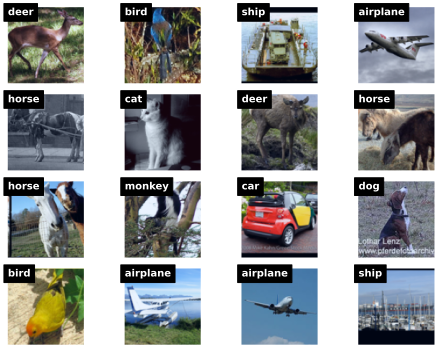

In [7]:
fig, axes = plt.subplots(4, 4, figsize=(7, 5))

for i, ax in enumerate(axes.flatten()):
    pic = X.data[i].numpy().transpose((1, 2, 0))
    pic = pic - np.min(pic)
    pic = pic / np.max(pic)

    label = trainset.classes[y[i]]

    ax.imshow(pic)
    ax.text(0, 0, label, ha='left', va='top', fontweight='bold', color='white', backgroundcolor='black')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Шаг 1: Нейросеть ResNet18

In [41]:
ResNet = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
ResNet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
from torchsummary import summary
summary(ResNet.to(device), (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [44]:
ResNet.to(device);

## Шаг 2.1: Обучение
### Feature Extraction: возьём готовую модель и обучим заново только полносвязные слои.

In [45]:
ResNet_fe = ResNet

In [46]:
for param in ResNet_fe.parameters():
    param.requires_grad = False

In [49]:
# Изменяем последний слой
ResNet_fe.fc = nn.Linear(512, 10)

In [50]:
optimizer = tch.optim.SGD(ResNet_fe.fc.parameters(), lr=0.0001, momentum=0.9)
loss_function = tch.nn.CrossEntropyLoss()

In [51]:
def train_model(train_loader, model, epochs, loss_function, optimizer):
    model= model.to(device)

    loss_history_model = []

    model.train()
    for epoch in tqdm(range(epochs)):
        for i, (batch, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            batch = batch.to(device)
            labels = labels.to(device)

            loss = loss_function(model(batch), labels)
            loss.backward()

            optimizer.step()

            loss_history_model.append(loss.cpu().item())

        print(f'Эпоха {epoch + 1} завершилась с лоссом на последнем батче = {loss.item()}')

    return loss_history_model

In [52]:
EPOCHS = 10
loss_model = train_model(train_loader, ResNet_fe, EPOCHS, loss_function, optimizer)

  0%|          | 0/10 [00:00<?, ?it/s]

Эпоха 1 завершилась с лоссом на последнем батче = 1.7413748502731323
Эпоха 2 завершилась с лоссом на последнем батче = 1.459646224975586
Эпоха 3 завершилась с лоссом на последнем батче = 1.2932881116867065
Эпоха 4 завершилась с лоссом на последнем батче = 1.2283419370651245
Эпоха 5 завершилась с лоссом на последнем батче = 1.0934852361679077
Эпоха 6 завершилась с лоссом на последнем батче = 1.072921633720398
Эпоха 7 завершилась с лоссом на последнем батче = 0.761742889881134
Эпоха 8 завершилась с лоссом на последнем батче = 0.7279500961303711
Эпоха 9 завершилась с лоссом на последнем батче = 0.8970882296562195
Эпоха 10 завершилась с лоссом на последнем батче = 0.9346652626991272


In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score


def ConfMatrix(loader, model):
    num_correct = 0
    num_samples = 0

    model.eval()

    with tch.no_grad(): # Не производить обратного подсчёта градиента, чтобы сеть не училась в процессе проверки
        for data, targets in loader:
            data = data.to(device) # Перевод данных на ранее объявленное железо для просчёта всех вычислений
            targets = targets.to(device) # Перевод целевых данных на карту
            preds = model(data) # Прямое распространение информации по сети
            _, predictions = preds.max(1) # Возвращаем позицию наибольшего выхода из сети

            cm = confusion_matrix(targets.cpu(), predictions.cpu())
            f = f1_score(predictions.cpu(),targets.cpu(), average='macro')

    model.train()

    return cm, f

## Шаг 3.1: Визуализация результатов

test F1 score =  0.6864851814851816
train F1 score =  0.7417748917748918


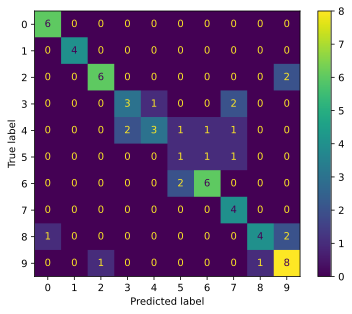

In [54]:
cm_test, f1_test = ConfMatrix(test_loader, ResNet_fe)
_, f1_train = ConfMatrix(train_loader, ResNet_fe)
ConfusionMatrixDisplay(cm_test).plot()

print('test F1 score = ', f1_test)
print('train F1 score = ', f1_train)

## Шаг 2.2: Обучение
### Fine-tuning: возьмём готовую модель и обучим заново полносвязные слои и дообучим часть свёрточных слоев

In [55]:
ResNet_ft = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [56]:
ResNet_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Что будем замораживать:

In [57]:
print(ResNet_ft.conv1)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [58]:
print(ResNet_ft.bn1)

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [59]:
print(ResNet_ft.relu)

ReLU(inplace=True)


In [60]:
print(ResNet_ft.maxpool)

MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)


In [61]:
print(ResNet_ft.layer1[:])

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [62]:
print(ResNet_ft.layer2[:])

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-

In [63]:
print(ResNet_ft.layer3[:])

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1

In [64]:
# Костыльный фризинг
for param in ResNet_ft.conv1.parameters():
    param.requires_grad = False

for param in ResNet_ft.bn1.parameters():
    param.requires_grad = False

for param in ResNet_ft.relu.parameters():
    param.requires_grad = False

for param in ResNet_ft.maxpool.parameters():
    param.requires_grad = False

for param in ResNet_ft.layer1[:].parameters():
    param.requires_grad = False

for param in ResNet_ft.layer2[:].parameters():
    param.requires_grad = False

for param in ResNet_ft.layer3[:].parameters():
    param.requires_grad = False

# Изменяем последний слой
ResNet_ft.fc = nn.Linear(512, 10)

In [65]:
weights = list(ResNet_ft.layer4[:].parameters()) + list(ResNet_ft.fc.parameters())

optimizer = tch.optim.SGD(weights, lr=0.0001, momentum=0.9)
loss_function = tch.nn.CrossEntropyLoss()

In [66]:
EPOCHS = 10
loss_model = train_model(train_loader, ResNet_ft, EPOCHS, loss_function, optimizer)

  0%|          | 0/10 [00:00<?, ?it/s]

Эпоха 1 завершилась с лоссом на последнем батче = 1.3814513683319092
Эпоха 2 завершилась с лоссом на последнем батче = 1.2113505601882935
Эпоха 3 завершилась с лоссом на последнем батче = 0.8978052735328674
Эпоха 4 завершилась с лоссом на последнем батче = 0.7529613971710205
Эпоха 5 завершилась с лоссом на последнем батче = 0.7260264158248901
Эпоха 6 завершилась с лоссом на последнем батче = 0.7813844680786133
Эпоха 7 завершилась с лоссом на последнем батче = 0.5700557231903076
Эпоха 8 завершилась с лоссом на последнем батче = 0.5034301280975342
Эпоха 9 завершилась с лоссом на последнем батче = 0.42970171570777893
Эпоха 10 завершилась с лоссом на последнем батче = 0.4432206451892853


## Шаг 3.2: Визуализация результатов

test F1 score =  0.8349017649017648
train F1 score =  0.9555555555555555


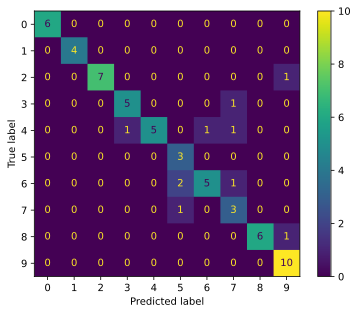

In [67]:
cm_test, f1_test = ConfMatrix(test_loader, ResNet_ft)
_, f1_train = ConfMatrix(train_loader, ResNet_ft)
ConfusionMatrixDisplay(cm_test).plot()

print('test F1 score = ', f1_test)
print('train F1 score = ', f1_train)

### Выводы:
1. Этот;
2. метод;
3. просто;
4. ИМБА.